In [12]:
import pyart
from matplotlib import pyplot as plt
import cartopy
from boto.s3.connection import S3Connection
import datetime
import tempfile
import numpy as np
import xarray
import netCDF4 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pytz
import os
import pandas as pd

%matplotlib inline

In [11]:
def extract_time(pd_dict, dt, varss=None, debug=False):
    obs_table = {}
    stations = list(pd_dict.keys())
    if varss is None:
        varss = list(pd_dict[stations[0]].keys())
    for var in varss:
        obs_table.update({var : np.array([])})
    for station in stations:
        try:
            if debug:
                print(station)
            idx = pd_dict[station].index.get_loc(dt, method='nearest')
            s = pd_dict[station].iloc[idx]
            for p in varss:
                obs_table[p] = np.append(obs_table[p], s[p])
        except:# pd.errors.InvalidIndexError:
            print(station, "something went wrong")
    return varss, obs_table

   
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    print(keys[index])
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    rain_z = radar.fields['reflectivity']['data'].copy()
    z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
    rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
    radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
    radar.fields['rain_z']['units'] = 'mm/h'
    radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
    radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
    radar.fields['rain_z']['valid_min'] = 0
    radar.fields['rain_z']['valid_max'] = 500
    return radar

In [14]:
metars_dir = '/Users/scollis/funded_projects/precip_change/data/highres2/'
all_metars = os.listdir(metars_dir)
pandas_dict = {}
for metars in all_metars:
    if '.csv' in metars:
        print(metars[0:-4])
        this_panda = pd.read_csv(metars_dir + metars)
        this_panda['date'] = pd.to_datetime(this_panda['time'])
        this_panda.index = this_panda['date']
        pandas_dict.update({metars[0:-4]:this_panda})
my_time = datetime.datetime(2017, 12, 5, 4)
meas, at_time = extract_time(pandas_dict, my_time)


CPBT
CPEH
CPFI
CPIR
CPRO
CPRY
CPST
CPSV
CPXL
CWAV
CWBO
CWBU
CWCF
CWCI
CWCJ
CWDK
CWDV
CWDZ
CWEH
CWEQ
CWFF
CWFJ
CWGM
CWGW
CWGY
CWHI
CWHN
CWII
CWIK
CWIW
CWJD
CWJI
CWJX
CWLB
CWLE
CWMQ
CWNK
CWOE
CWOY
CWPO
CWRJ
CWRM
CWRT
CWRY
CWSR
CWVI
CWVN
CWVP
CWWF
CWWS
CWXL
CWZS
CXAF
CXAG
CXAJ
CXAK
CXBA
CXBK
CXBR
CXBW
CXCA
CXCP
CXCS
CXDB
CXDP
CXDW
CXEA
CXEC
CXEG
CXFM
CXGH
CXHD
CXHR
CXKM
CXMD
CXMO
CXOL
CXOY
CXPL
CXRL
CXSC
CXSL
CXSP
CXTH
CXVM
CXWM
CXWN
CYBR
CYBU
CYBW
CYDN
CYED
CYEG
CYEN
CYGQ
CYHD
CYIV
CYKY
CYLJ
CYLL
CYNE
CYOD
CYPA
CYPL
CYQD
CYQF
CYQK
CYQL
CYQR
CYQT
CYQV
CYQW
CYRL
CYTL
CYWG
CYXE
CYXH
CYXL
CYYC
CYYN
CZMJ
CZMU
CZOL
CZPC
CZPS
CZTB
K04V
K0CO
K1H2
K20V
K2WX
K3LF
K4BM
K5SM
K7BM
K8D3
K9V9
KAAA
KACB
KACQ
KADC
KADU
KAEL
KAFF
KAFK
KAIA
KAIG
KAIO
KAIT
KAJG
KAKO
KALN
KALO
KAMW
KANE
KANW
KAQP
KARG
KARR
KARV
KASG
KASW
KATW
KATY
KAUH
KAUM
KAVK
KAWG
KAWM
KAXA
KAZO
KBAK
KBBB
KBBW
KBDE
KBDH
KBEH
KBFW
KBIE
KBIV
KBJC
KBJI
KBKF
KBLV
KBMG
KBMI
KBNA
KBNW
KBPI
KBRL
KBTL
KBUU
KBVN
KBVX
KBWG
KBWP
KBYH
KBYI
KBZN
KC09


In [18]:
pandas_dict['KLOT'].keys()

Index(['air_temperature', 'dew_point_temperature', 'inches_ALTIM',
       'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather',
       'precipitation_amount_hourly', 'precipitation_amount_24', 'time',
       'timestr', 'station', 'lat', 'lon', 'date'],
      dtype='object')

<Key: noaa-nexrad-level2,2017/12/04/KLOT/KLOT20171204_125802_V06>
<Key: noaa-nexrad-level2,2017/12/04/KILX/KILX20171204_125948_V06>
<Key: noaa-nexrad-level2,2017/12/04/KDVN/KDVN20171204_125833_V06>
Monday December 04 at 06:58 AM CST
<Key: noaa-nexrad-level2,2017/12/04/KLOT/KLOT20171204_140013_V06>
<Key: noaa-nexrad-level2,2017/12/04/KILX/KILX20171204_135740_V06>
<Key: noaa-nexrad-level2,2017/12/04/KDVN/KDVN20171204_140101_V06>
Monday December 04 at 08:00 AM CST
<Key: noaa-nexrad-level2,2017/12/04/KLOT/KLOT20171204_150047_V06>
<Key: noaa-nexrad-level2,2017/12/04/KILX/KILX20171204_145638_V06>
<Key: noaa-nexrad-level2,2017/12/04/KDVN/KDVN20171204_145847_V06>
Monday December 04 at 09:00 AM CST
<Key: noaa-nexrad-level2,2017/12/04/KLOT/KLOT20171204_160055_V06>
<Key: noaa-nexrad-level2,2017/12/04/KILX/KILX20171204_160431_V06>
<Key: noaa-nexrad-level2,2017/12/04/KDVN/KDVN20171204_160030_V06>
Monday December 04 at 10:00 AM CST
<Key: noaa-nexrad-level2,2017/12/04/KLOT/KLOT20171204_170212_V06>
<K

/Users/scollis/anaconda/envs/pchange/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Key: noaa-nexrad-level2,2017/12/05/KLOT/KLOT20171205_100401_V06>
<Key: noaa-nexrad-level2,2017/12/05/KILX/KILX20171205_095824_V06>
<Key: noaa-nexrad-level2,2017/12/05/KDVN/KDVN20171205_095531_V06>
Tuesday December 05 at 04:04 AM CST


/Users/scollis/anaconda/envs/pchange/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Key: noaa-nexrad-level2,2017/12/05/KLOT/KLOT20171205_110240_V06>
<Key: noaa-nexrad-level2,2017/12/05/KILX/KILX20171205_105634_V06>
<Key: noaa-nexrad-level2,2017/12/05/KDVN/KDVN20171205_110357_V06>
Tuesday December 05 at 05:02 AM CST


/Users/scollis/anaconda/envs/pchange/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Key: noaa-nexrad-level2,2017/12/05/KLOT/KLOT20171205_120120_V06>
<Key: noaa-nexrad-level2,2017/12/05/KILX/KILX20171205_120425_V06>
<Key: noaa-nexrad-level2,2017/12/05/KDVN/KDVN20171205_120234_V06>
Tuesday December 05 at 06:01 AM CST


/Users/scollis/anaconda/envs/pchange/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


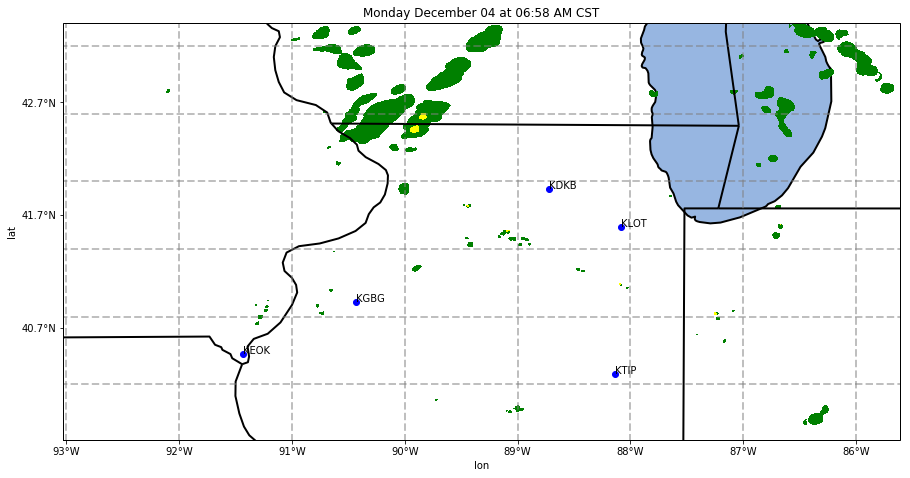

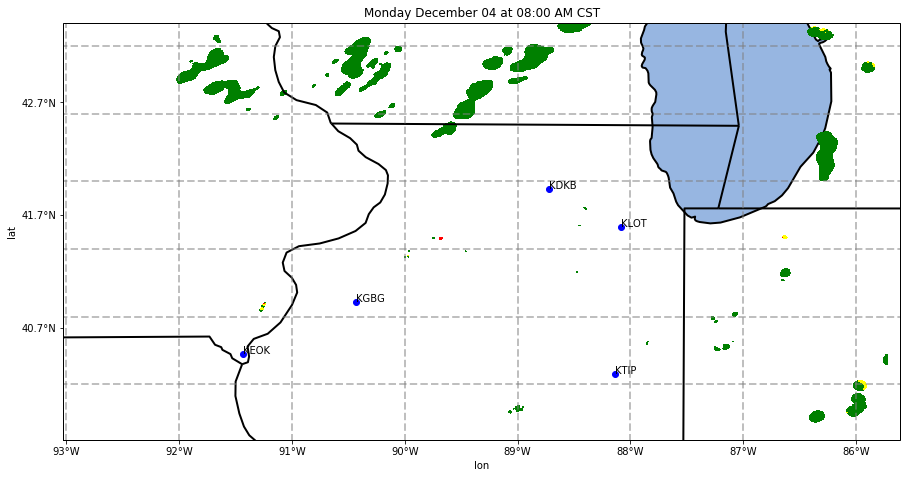

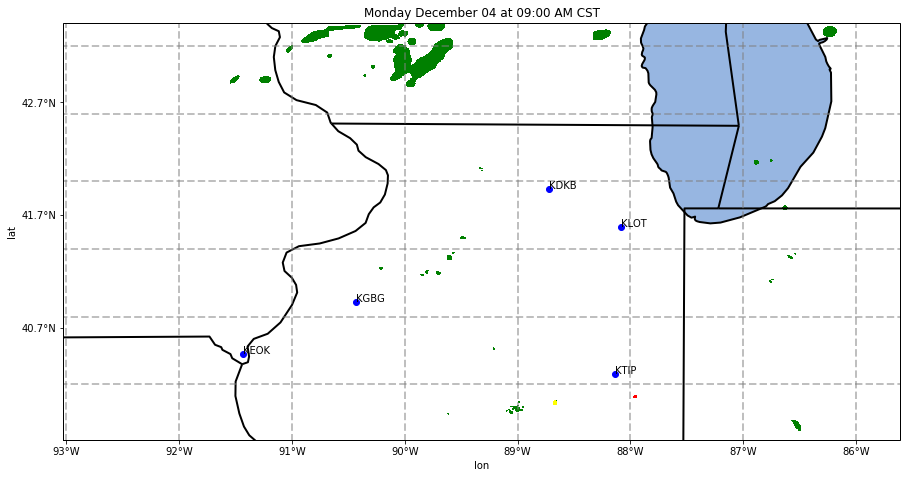

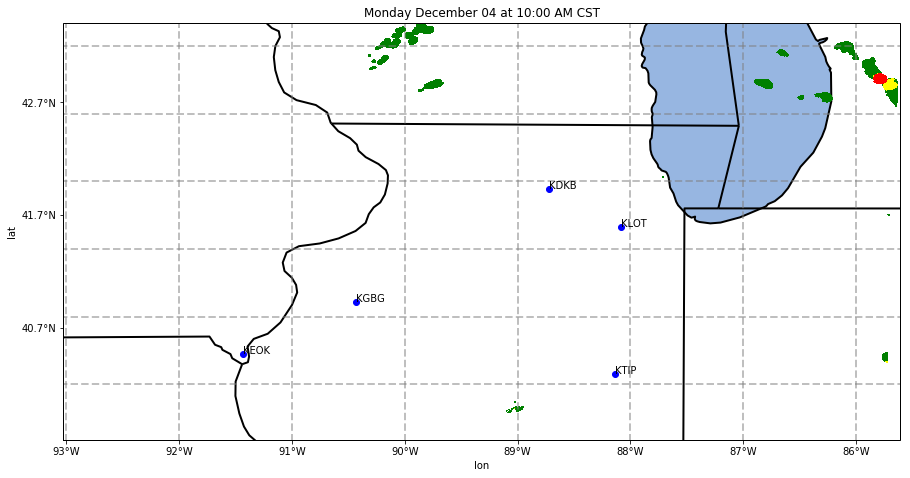

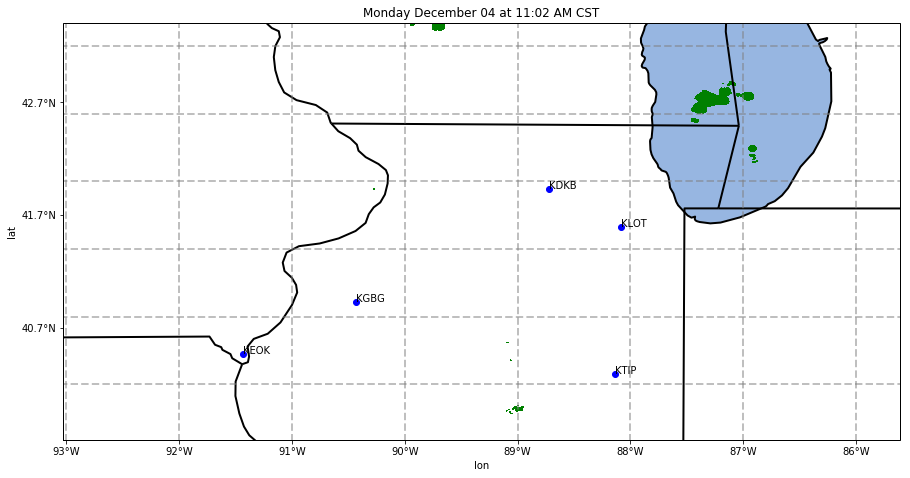

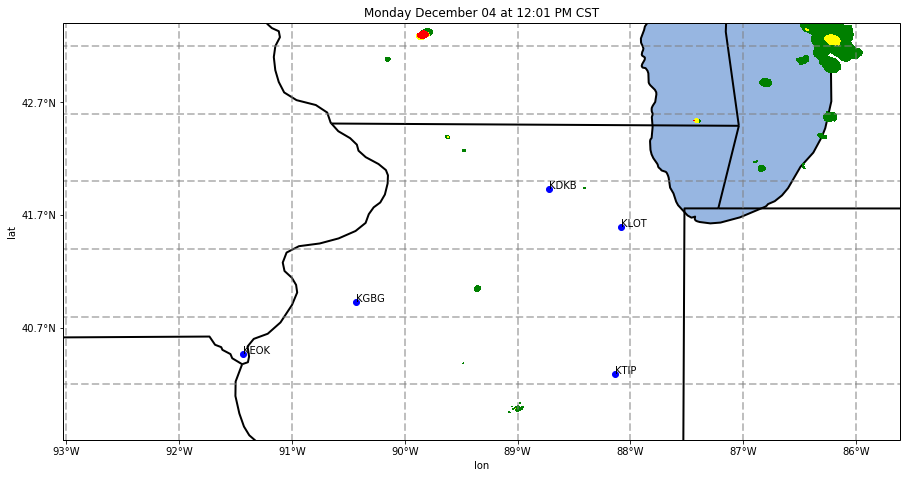

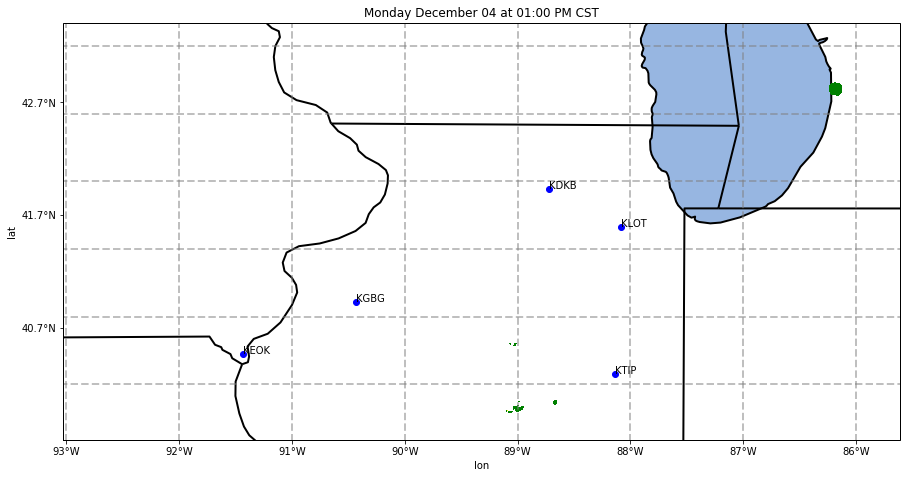

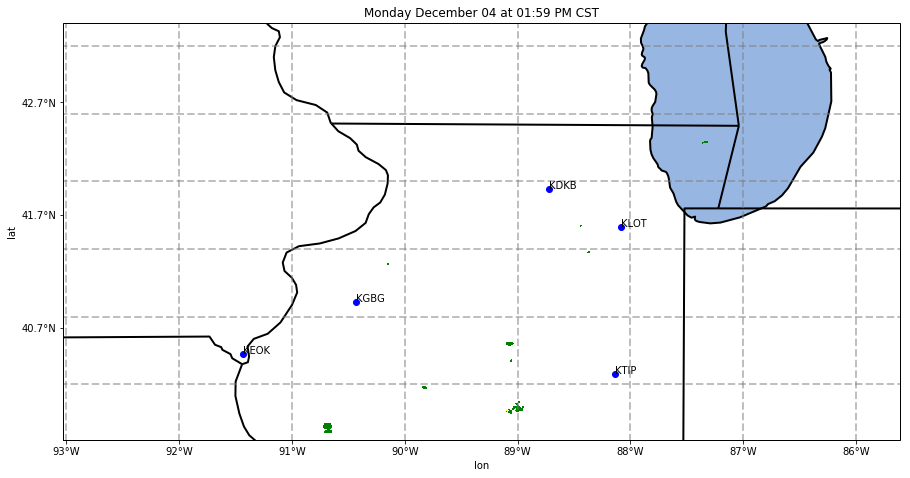

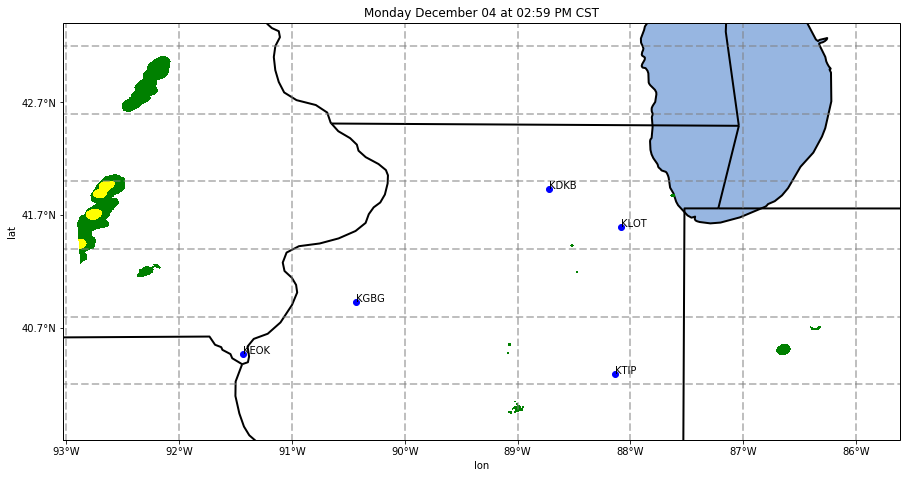

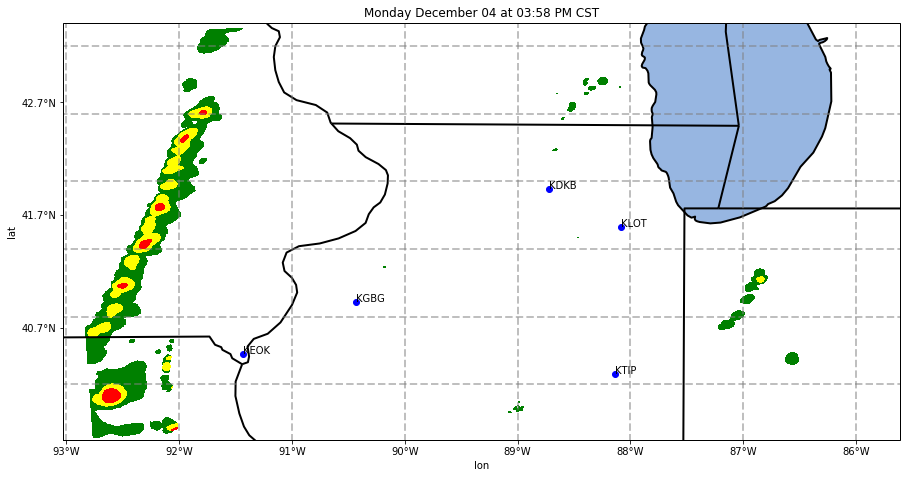

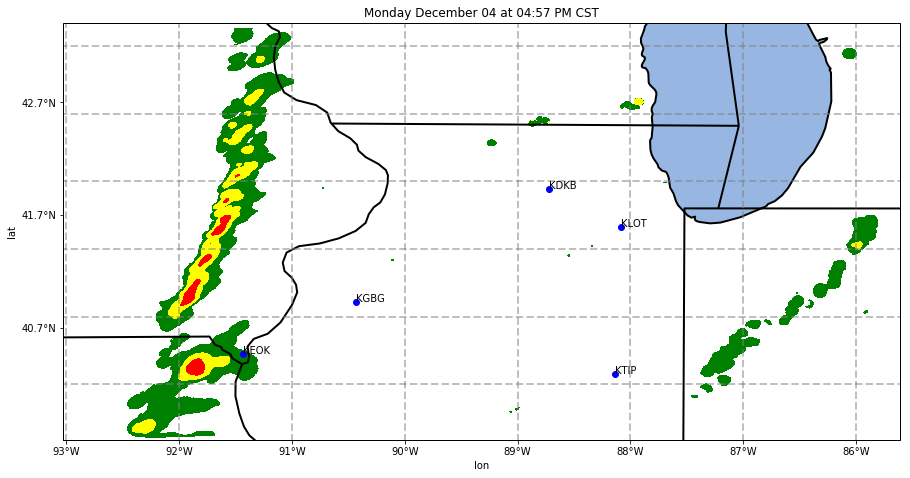

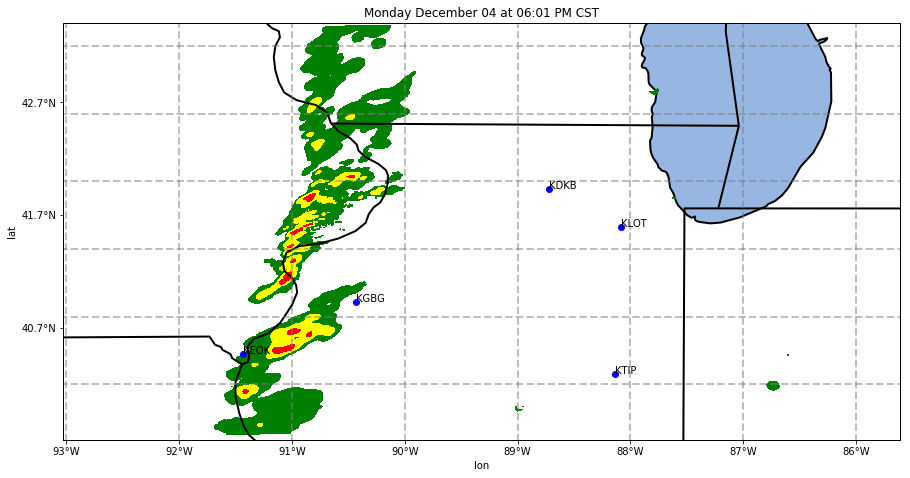

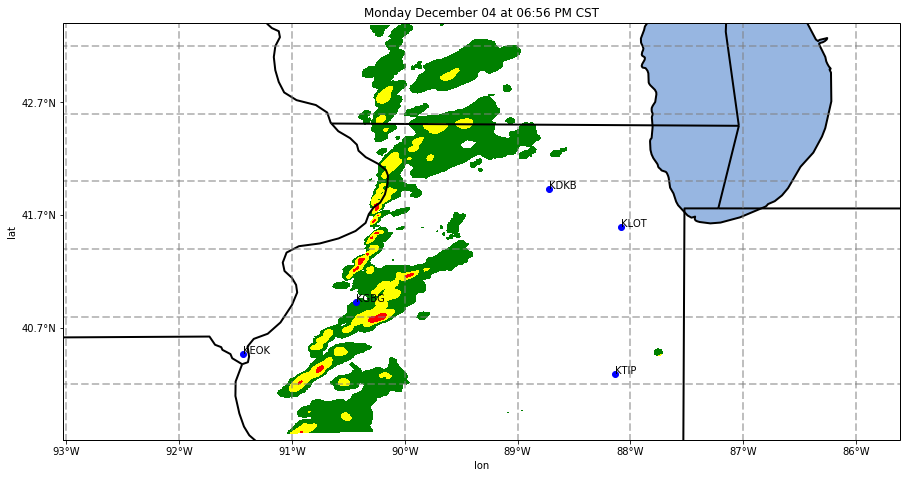

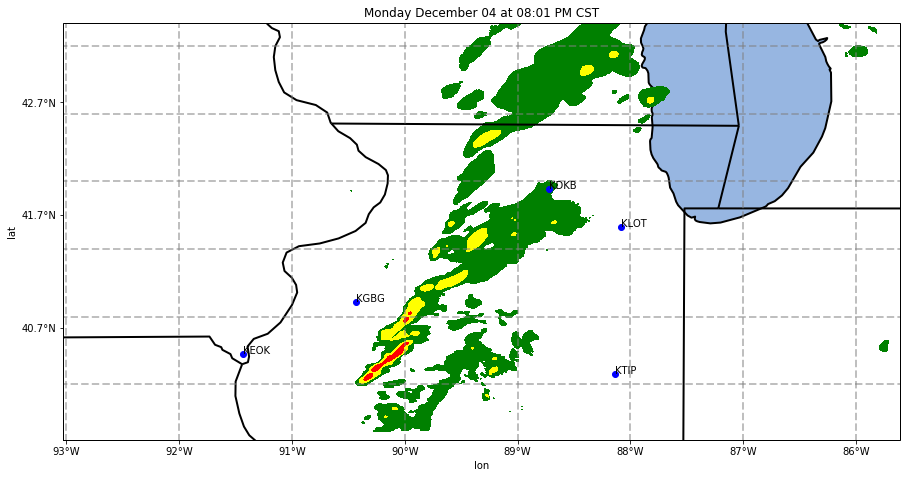

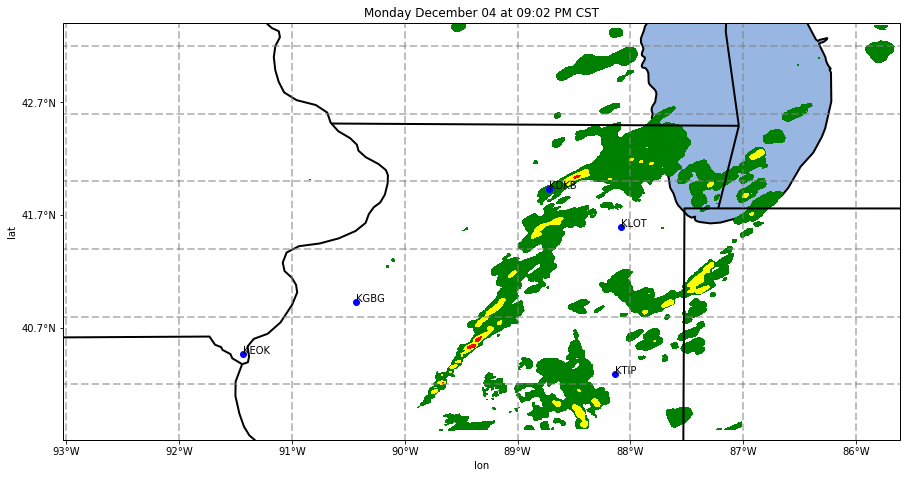

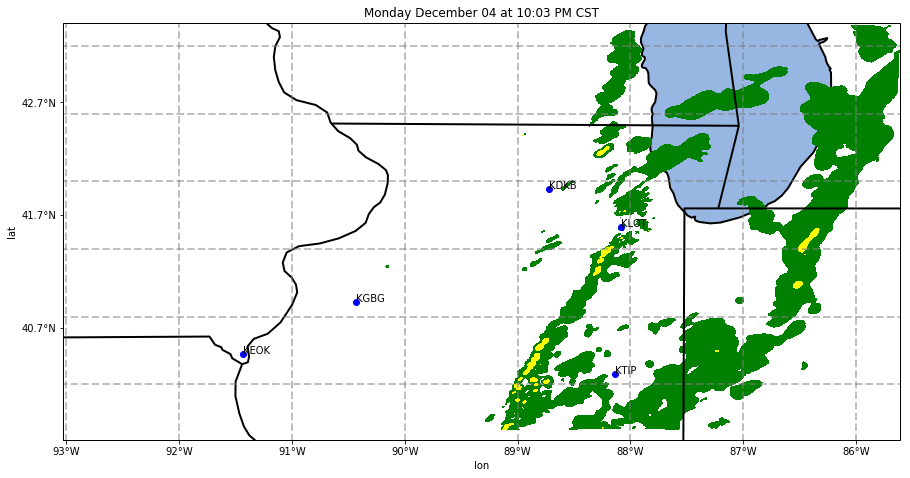

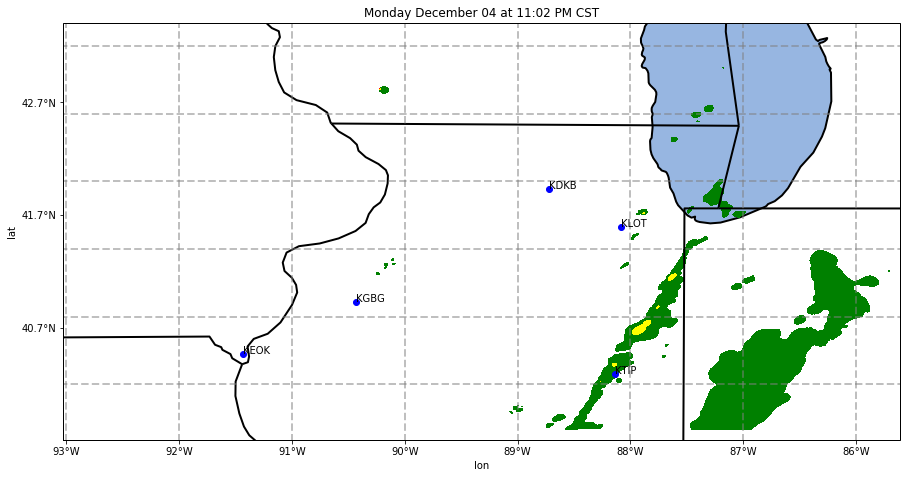

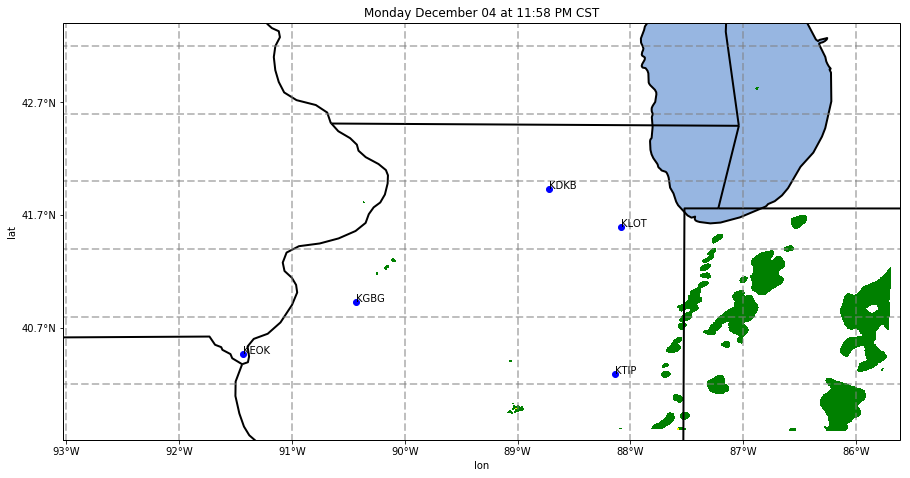

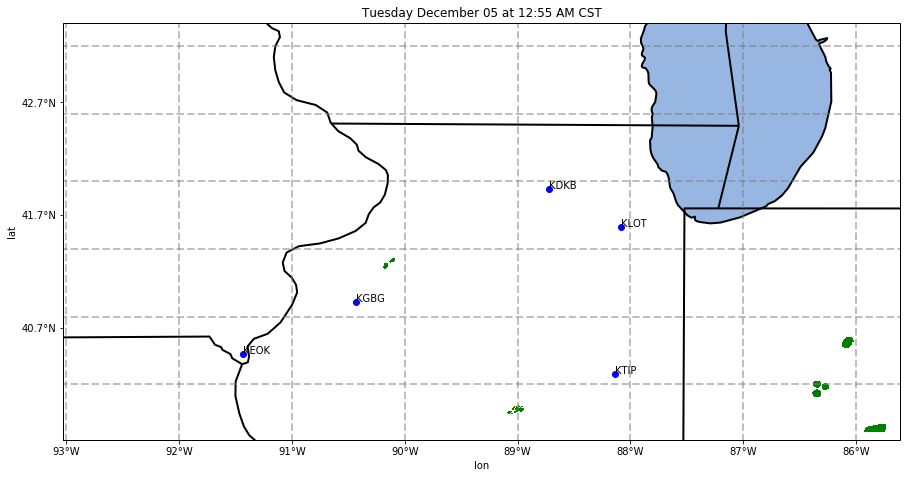

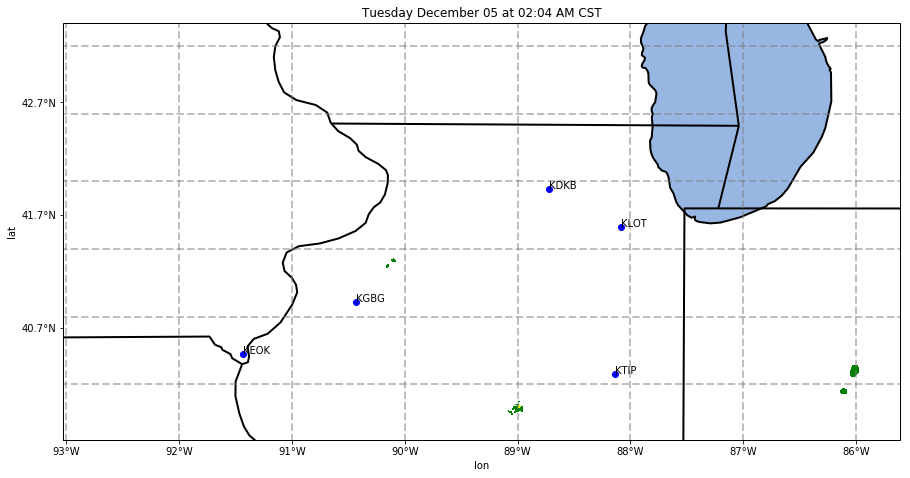

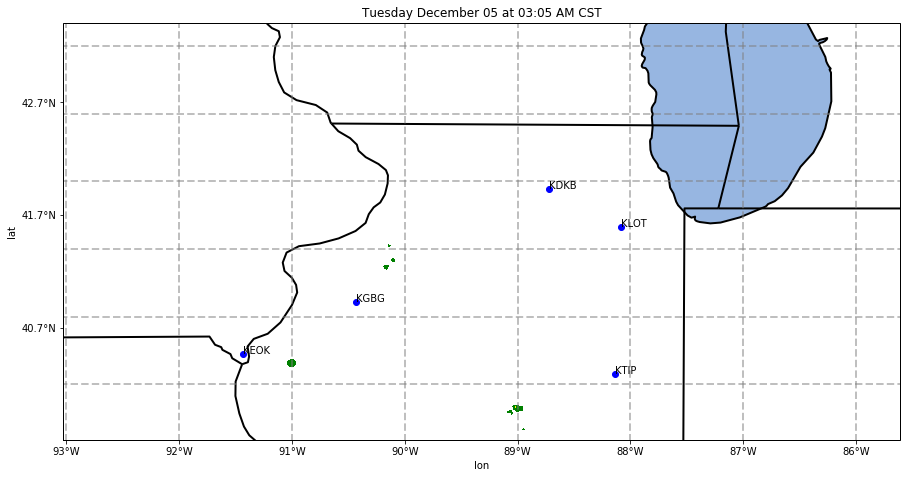

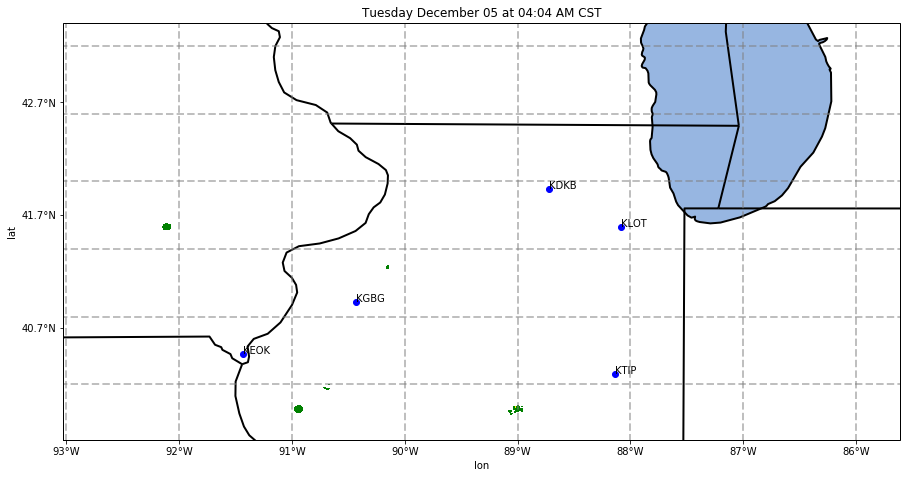

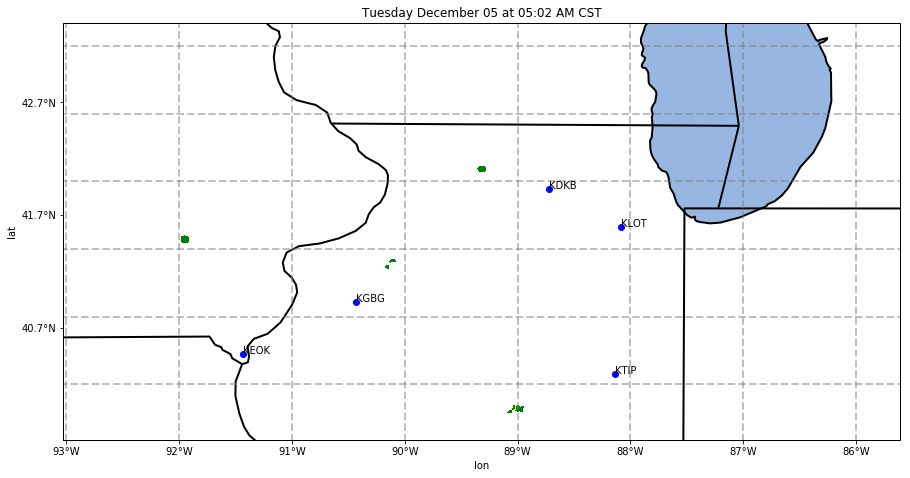

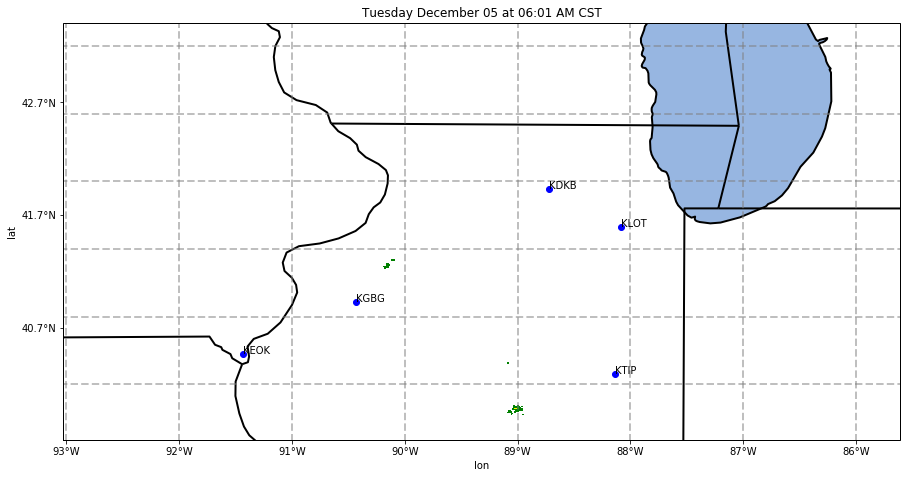

In [49]:
my_datetime = datetime.datetime(2017,12, 4, 12, 0)
for i in range(24):
    my_datetime += datetime.timedelta(hours=1)
    klot = get_radar_from_aws('KLOT', my_datetime)
    kilx = get_radar_from_aws('KILX', my_datetime)
    kdvn = get_radar_from_aws('KDVN', my_datetime)


    sweep = 0
    index_at_start = klot.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = netCDF4.num2date(klot.time['data'][index_at_start], 
                                      klot.time['units'])
    pacific = pytz.timezone('US/Central')
    local_time = pacific.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    print(fancy_date_string)
    strfmt = my_datetime.strftime('%Y%m%d_%H%M')
    #speckles_kdvn = pyart.correct.despeckle.despeckle_field(kdvn, 'reflectivity')
    #speckles_kilx = pyart.correct.despeckle.despeckle_field(kilx, 'reflectivity')
    #speckles_klot = pyart.correct.despeckle.despeckle_field(klot, 'reflectivity')
    #grids = pyart.map.grid_from_radars((klot, kilx, kdvn),(1,801,801),
    #                   ((1000.,1001.),(-200000.,200000.),(-600000.,200000.)),
    #                   fields=['reflectivity'],
    #                   refl_field='reflectivity', 
    #                   gatefilters=(speckles_klot, speckles_kilx, 
    #                                speckles_kdvn))

    grids = pyart.map.grid_from_radars((klot, kilx, kdvn),(1,801,801),
                       ((1000.,1001.),(-200000.,200000.),(-400000.,200000.)),
                       fields=['reflectivity', 'rain_z'],
                       refl_field='reflectivity')

    long, lat = grids.get_point_longitude_latitude()
    height = grids.point_z['data'][:,0,0]
    time = np.array([ netCDF4.num2date(grids.time['data'][0], grids.time['units'])])
    ds = xarray.Dataset()
    for this_field in list(grids.fields.keys()):
        this_data = grids.fields[this_field]['data']
        my_data = xarray.DataArray(np.ma.expand_dims(this_data,0),
                                   dims = ('time', 'z', 'y', 'x'),
                                   coords = {'time' : (['time'], time),
                                             'z' : (['z'], height),
                                             'lat' :(['y','x'], lat),
                                             'lon' : (['y','x'],long),
                                              'y' : (['y'],lat[:,0]),
                                              'x' : (['x'],long[0,:])})

        for this_meta in list(grids.fields[this_field].keys()):
            if this_meta is not 'data':
                my_data.attrs.update({this_meta: grids.fields[this_field][this_meta]})

        ds[this_field] = my_data
        ds.lon.attrs = [('long_name', 'longitude of grid cell center'),
                 ('units', 'degrees_east')]
        ds.lat.attrs = [('long_name', 'latitude of grid cell center'),
                 ('units', 'degrees_north')]
        ds.z.attrs['long_name'] = "height above sea sea level"
        ds.z.attrs['units'] = "m"

        ds.z.encoding['_FillValue'] = None
        ds.lat.encoding['_FillValue'] = None
        ds.lon.encoding['_FillValue'] = None

    lat_lines = np.arange(np.around(ds.lat.min(), decimals=1), 
                          ds.lat.max(), 1)
    lon_lines = np.arange(np.around(ds.lon.min(),decimals=1),
                          ds.lon.max(), 1)

    fig = plt.figure(figsize=[15,10])

    my_ax = plt.subplot(projection = ccrs.PlateCarree())

    z_var = ds.reflectivity[0].sel(z=1000, method='nearest')
    r_var = ds.rain_z[0].sel(z=1000, method='nearest')
    pc = r_var.where(r_var > .5).plot.contourf(transform=ccrs.PlateCarree(), ax=my_ax,
                                                    x='lon', y='lat',
                                                    add_colorbar=False, levels=[.5,10,50], 
                                               colors=['green', 'yellow', 'red'])

    #cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
    #cb1.set_label('Meshed reflectivity (dBZ)')

    my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
    my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    my_ax.xaxis.set_major_formatter(lon_formatter)
    my_ax.yaxis.set_major_formatter(lat_formatter)
    gl = my_ax.gridlines(draw_labels=False,
                                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='50m', facecolor='none')

    states = cartopy.feature.NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

    coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                                facecolor='none', name='coastline')

    lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                            edgecolor='face',
                                            facecolor=cartopy.feature.COLORS['water'])

    my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
    my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
    my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
    my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                     zorder=0)

    for st in ['KLOT', 'KTIP', 'KDKB', 'KEOK','KGBG']:
        plt.plot(pandas_dict[st]['lon'][0], pandas_dict[st]['lat'][0], 'bo')
        plt.text(pandas_dict[st]['lon'][0], pandas_dict[st]['lat'][0], st)


    extent = [ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()]
    my_ax.set_extent(extent)
    plt.title(fancy_date_string)
    plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

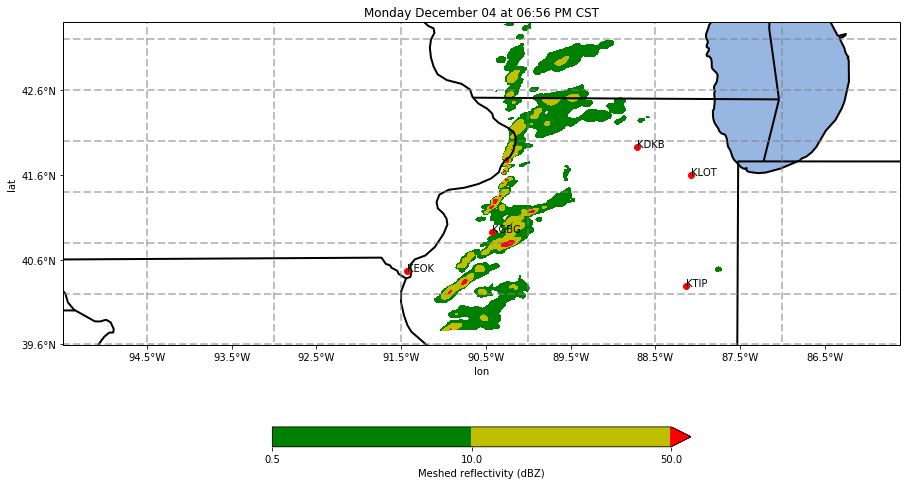

In [42]:
fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

z_var = ds.reflectivity[0].sel(z=1000, method='nearest')
r_var = ds.rain_z[0].sel(z=1000, method='nearest')
pc = r_var.where(r_var > 1).plot.contourf(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', colors=['g','y', 'r'],
                                                add_colorbar=False, levels=[0.5, 10, 50], vmin = 1)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed reflectivity (dBZ)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)


for st in ['KLOT', 'KTIP', 'KDKB', 'KEOK','KGBG']:
    plt.plot(pandas_dict[st]['lon'][0], pandas_dict[st]['lat'][0], 'bo')
    plt.text(pandas_dict[st]['lon'][0], pandas_dict[st]['lat'][0], st)

extent = [ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

In [23]:
plt.text?

In [46]:
klot.gate_x['data']

array([[   1241.33195168,    1387.37076153,    1533.40957138, ...,
         268010.41904241,  268155.94913245,  268301.46096734],
       [   1224.89883727,    1369.00437588,    1513.10991448, ...,
         264448.10531699,  264591.7277253 ,  264735.29609281],
       [   1208.94759497,    1351.17645417,    1493.40531336, ...,
         261000.98670911,  261142.70344857,  261284.40240899],
       ..., 
       [  -1746.69710567,   -1952.18096166,   -2157.6629844 , ...,
        -373799.20061491, -374000.4056536 , -374201.55854636],
       [  -1765.70542264,   -1973.42544326,   -2181.14361066, ...,
        -377867.04596027, -378070.44059963, -378273.78252559],
       [  -1785.16668368,   -1995.17615387,   -2205.18375043, ...,
        -382031.82289474, -382237.45931017, -382443.04243121]])